## ドラッグストア売上予測
https://www.kaggle.com/c/rossmann-store-sales  

背景  
Rossmannはヨーロッパのドラッグストアです。  
本プロジェクトはRossmannの過去の売れ行き情報で、将来の売上を予測します。  

評価方法：RMSPE= ｓｑｒｔ（1/n  * sum((y_act-y_pred)/y)^2）

_※本スクリプトは基礎集計だけ行います。_

### データ理解と観察

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 


In [3]:
st = pd.read_csv('./data/store.csv')
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

#### カラム情報

In [4]:
st.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [5]:
train_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [6]:
test_df.columns

Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday'],
      dtype='object')

In [7]:
st.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
train_df.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


#### カラムのタイプ

In [9]:
st.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


### EDA
探索的な分析（処理しながら分析）  

#### 店舗の情報を訓練データに付与

In [12]:
df = pd.merge(train_df,st,on='Store',how='left')
df.count()

Store                        1017209
DayOfWeek                    1017209
Date                         1017209
Sales                        1017209
Customers                    1017209
Open                         1017209
Promo                        1017209
StateHoliday                 1017209
SchoolHoliday                1017209
StoreType                    1017209
Assortment                   1017209
CompetitionDistance          1014567
CompetitionOpenSinceMonth     693861
CompetitionOpenSinceYear      693861
Promo2                       1017209
Promo2SinceWeek               509178
Promo2SinceYear               509178
PromoInterval                 509178
dtype: int64

訓練データに欠損ない  
店舗の情報に関して個別に欠損  
競合に関する欠損が存在、それは競合がないかまた競合情報手に入れくれないかのどちらか  
プロモーション情報に関して欠損が存在、ただプロモーション情報に欠損が存在している店舗はプロモーションを行っていない  
時系列データなので、個別の欠損に数多くの欠損が出てきた  


#### 欠損の処理

In [13]:
st[st['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


ライバルがなければ、ライバルとの距離というデータもない

In [14]:
st[st['CompetitionOpenSinceMonth'].isnull()].head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"


In [15]:
st[st['CompetitionOpenSinceYear'].isnull()].head(5) 

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"


CompetitionOpenSinceMonth、CompetitionOpenSinceYear  
ライバルの開業月  
単純にライバルの開業月がわからない可能性があるので、ここで平均値で補完する予定

In [16]:
print(st[st['Promo2SinceWeek'].isnull()].shape)
print(st[st['Promo2SinceYear'].isnull()].shape)
print(st[st['PromoInterval'].isnull()].shape)

(544, 10)
(544, 10)
(544, 10)


プロモーションに参加しない場合はNULL

In [14]:
cols1 = ['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear']
st[cols1] = st[cols1].fillna(st[cols1].mean()).astype(int)

st['Promo2SinceYear'] = st['Promo2SinceYear'].fillna(2016)
st['Promo2SinceWeek'] = st['Promo2SinceWeek'].fillna(0)

st['PromoInterval'] = st['PromoInterval'].fillna('NoPromo')

In [15]:
st.isnull().any()

Store                        False
StoreType                    False
Assortment                   False
CompetitionDistance          False
CompetitionOpenSinceMonth    False
CompetitionOpenSinceYear     False
Promo2                       False
Promo2SinceWeek              False
Promo2SinceYear              False
PromoInterval                False
dtype: bool

これで欠損がなくなり、再結合する  

In [16]:
df = pd.merge(train_df,st,on = 'Store',how='left')

In [17]:
df.count()

Store                        1017209
DayOfWeek                    1017209
Date                         1017209
Sales                        1017209
Customers                    1017209
Open                         1017209
Promo                        1017209
StateHoliday                 1017209
SchoolHoliday                1017209
StoreType                    1017209
Assortment                   1017209
CompetitionDistance          1017209
CompetitionOpenSinceMonth    1017209
CompetitionOpenSinceYear     1017209
Promo2                       1017209
Promo2SinceWeek              1017209
Promo2SinceYear              1017209
PromoInterval                1017209
dtype: int64

#### 異常値を処理

__df__


In [18]:
df = df[ｄｆ['Sales']!=0]

In [19]:
df.describe().round(2)

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,844338.00,844338.00,844338.00,844338.00,844338.0,844338.00,844338.00,844338.00,844338.00,844338.00,844338.0,844338.00,844338.00
mean,558.42,3.52,6955.96,762.78,1.0,0.45,0.19,5458.02,7.15,2008.48,0.5,11.60,2013.88
std,321.73,1.72,3103.82,401.19,0.0,0.50,0.40,7799.46,2.65,4.95,0.5,15.31,2.43
min,1.00,1.00,46.00,8.00,1.0,0.00,0.00,20.00,1.00,1900.00,0.0,0.00,2009.00
25%,280.00,2.00,4859.00,519.00,1.0,0.00,0.00,710.00,6.00,2008.00,0.0,0.00,2012.00
50%,558.00,3.00,6369.00,676.00,1.0,0.00,0.00,2330.00,7.00,2008.00,0.0,0.00,2016.00
75%,837.00,5.00,8360.00,893.00,1.0,1.00,0.00,6880.00,9.00,2011.00,1.0,22.00,2016.00
max,1115.00,7.00,41551.00,7388.00,1.0,1.00,1.00,75860.00,12.00,2015.00,1.0,50.00,2016.00


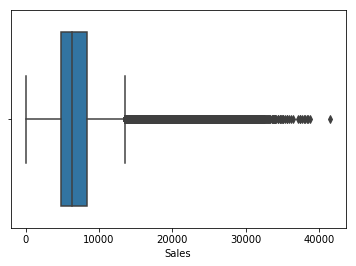

In [20]:
sns.boxplot(df['Sales'])
# plt.savefig('./pic/sales_plot.png')

In [21]:
df.sort_values('Sales',ascending=False).round(2)[['Sales','Customers']].head(10)

,Sales,Customers
44393,41551,1721
132946,38722,5132
101726,38484,5458
87231,38367,5192
424086,38037,1970
627776,38025,4381
627220,37646,1964
444361,37403,5297
620531,37376,4916
245945,37122,4962


In [22]:
df['SalesPerCustomer']=df['Sales']/df['Customers']

In [23]:
df['SalesPerCustomer'].describe().round(2)

count    844338.00
mean          9.49
std           2.20
min           2.75
25%           7.90
50%           9.25
75%          10.90
max          64.96
Name: SalesPerCustomer, dtype: float64

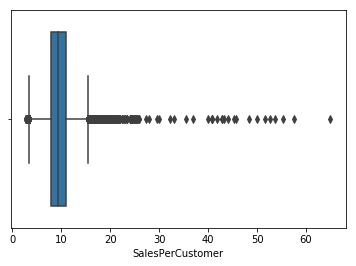

In [24]:
sns.boxplot(df['SalesPerCustomer'])
# plt.savefig('./pic/sales_per_customer_plot.png')

In [25]:
df = df[df['SalesPerCustomer']<=30]
# df = df[df['SalesPerCustomer']>0]

In [26]:
st.sort_values('CompetitionOpenSinceYear').head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
814,815,a,a,590,1,1900,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
145,146,d,c,8050,10,1961,1,48.0,2012.0,"Jan,Apr,Jul,Oct"
540,541,a,c,650,7,1990,0,0.0,2016.0,NoPromo
328,329,a,a,1310,6,1990,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
991,992,a,a,2480,7,1990,0,0.0,2016.0,NoPromo


1900年開業の店舗は単純に老舗店舗と考えられる、処理する必要なし

データタイプ確認

In [27]:
df.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance            int64
CompetitionOpenSinceMonth      int64
CompetitionOpenSinceYear       int64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
SalesPerCustomer             float64
dtype: object

In [28]:
df['SchoolHoliday'].unique()

array([1, 0])

In [29]:
df['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [30]:
df['StateHoliday']=df['StateHoliday'].astype(str)
# df['StateHoliday'].unique()

In [31]:
print(df['Date'].min() )
print(df['Date'].max() )

2013-01-01
2015-07-31


In [32]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'SalesPerCustomer'],
      dtype='object')

In [33]:
df.describe().round(1)[['Store', 'Sales', 'Customers',
       'CompetitionDistance',
       'CompetitionOpenSinceYear', 
       'Promo2SinceYear','SalesPerCustomer']].T

,count,mean,std,min,25%,50%,75%,max
Store,844315.0,558.4,321.7,1.0,280.0,558.0,837.0,1115.0
Sales,844315.0,6955.6,3103.0,46.0,4859.0,6369.0,8360.0,41551.0
Customers,844315.0,762.8,401.2,8.0,519.0,676.0,893.0,7388.0
CompetitionDistance,844315.0,5458.1,7799.6,20.0,710.0,2330.0,6880.0,75860.0
CompetitionOpenSinceYear,844315.0,2008.5,4.9,1900.0,2008.0,2008.0,2011.0,2015.0
Promo2SinceYear,844315.0,2013.9,2.4,2009.0,2012.0,2016.0,2016.0,2016.0
SalesPerCustomer,844315.0,9.5,2.2,2.7,7.9,9.2,10.9,29.9


### 基礎集計

店舗に関して

In [34]:
st.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270,9,2008,0,0.0,2016.0,NoPromo
1,2,a,a,570,11,2007,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130,12,2006,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620,9,2009,0,0.0,2016.0,NoPromo
4,5,a,a,29910,4,2015,0,0.0,2016.0,NoPromo


In [35]:
print(df['Date'].min(),df['Date'].max())

2013-01-01 2015-07-31


In [36]:
df.count()

Store                        844315
DayOfWeek                    844315
Date                         844315
Sales                        844315
Customers                    844315
Open                         844315
Promo                        844315
StateHoliday                 844315
SchoolHoliday                844315
StoreType                    844315
Assortment                   844315
CompetitionDistance          844315
CompetitionOpenSinceMonth    844315
CompetitionOpenSinceYear     844315
Promo2                       844315
Promo2SinceWeek              844315
Promo2SinceYear              844315
PromoInterval                844315
SalesPerCustomer             844315
dtype: int64

In [37]:
test_df.count()

Id               41088
Store            41088
DayOfWeek        41088
Date             41088
Open             41077
Promo            41088
StateHoliday     41088
SchoolHoliday    41088
dtype: int64

In [38]:
df['Sales'].describe().round(2)

count    844315.00
mean       6955.62
std        3103.03
min          46.00
25%        4859.00
50%        6369.00
75%        8360.00
max       41551.00
Name: Sales, dtype: float64

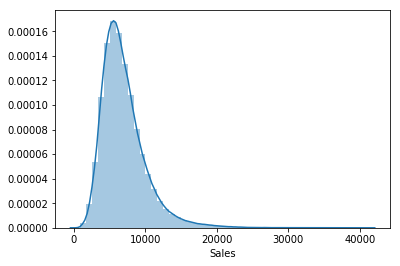

In [39]:
sns.distplot(df['Sales'])
plt.savefig('sales_plot.png')

In [40]:
st.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

StoreType
a    602
b     17
c    148
d    348
Name: Store, dtype: int64

Text(0.5, 1.0, 'STORE TYPE')

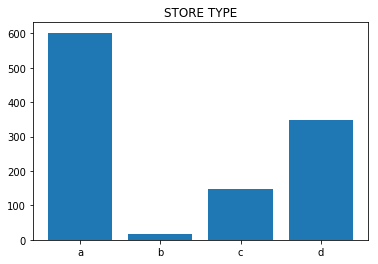

In [41]:
bar1 = st.groupby('StoreType').count()
display(bar1['Store'])
plt.bar( x=bar1.index , height=bar1['Store'] )
plt.title('STORE TYPE')

# plt.savefig('./pic/store_type.png')

a最多

Assortment
a    593
b      9
c    513
Name: Store, dtype: int64

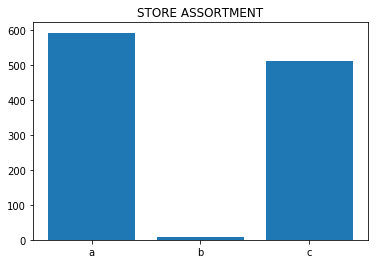

In [42]:
bar2 = st.groupby('Assortment').count()
plt.title('STORE ASSORTMENT')
display(bar2['Store'])
plt.bar(x=bar2.index,height=bar2['Store']);
# plt.savefig('./pic/store_assortment.png')

店舗のタイプに関して、AかCがメインです。

In [43]:
st.groupby(['StoreType','Assortment']).count()['Store']

StoreType  Assortment
a          a             381
           c             221
b          a               7
           b               9
           c               1
c          a              77
           c              71
d          a             128
           c             220
Name: Store, dtype: int64

Text(0.5, 1.0, 'Promo2')

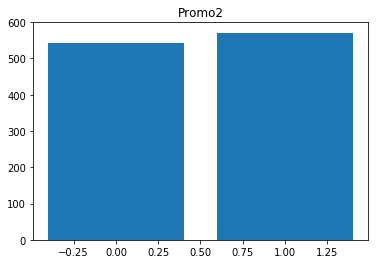

In [44]:

promo2_count = st.groupby('Promo2').count()
plt.bar(x=promo2_count.index,height=promo2_count['Store']);
plt.title('Promo2')
# plt.savefig('./pic/Promo2.png')

連続販促に参加する店舗としない店舗の数は大差ない  

Text(0.5, 1.0, 'Promo2 interval')

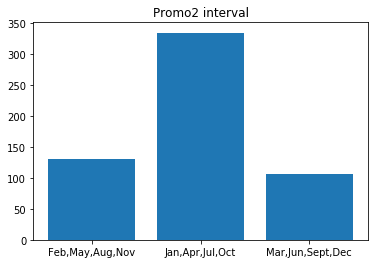

In [45]:
promo2_interval_count = st[st['PromoInterval']!='NoPromo'].groupby('PromoInterval').count()
plt.bar(x=promo2_interval_count.index,height= promo2_interval_count['Store']);
plt.title('Promo2 interval')
# plt.savefig('./pic/Promo2.png')

参加の場合、基本的に3か月に1回参加する。パターンは3パターンあります。  


マスターデータの単独集計は以上  

train を単体集計  

In [46]:
train_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [47]:
train_df.groupby('StateHoliday').count()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday
StateHoliday,,,,,,,,
0,131072,131072,131072,131072,131072,131072,131072,131072
0,855087,855087,855087,855087,855087,855087,855087,855087
a,20260,20260,20260,20260,20260,20260,20260,20260
b,6690,6690,6690,6690,6690,6690,6690,6690
c,4100,4100,4100,4100,4100,4100,4100,4100


0=0 a=1 b=2 c=3 に置き換えましょう。  

In [49]:
# train_df['StateHoliday'] = train_df['StateHoliday'].replace({'a':1,'b':2,'c':3}).astype(int)

SchoolHoliday観察

In [57]:
date_holiday = train_df[['Date','StateHoliday','SchoolHoliday','Open']]
date_holiday.groupby('StateHoliday').count()

,Date,SchoolHoliday,Open
StateHoliday,,,
0,131072,131072,131072
0,855087,855087,855087
a,20260,20260,20260
b,6690,6690,6690
c,4100,4100,4100


時系列的な観察

In [58]:
def plot_ts(feature,freq):
#     date_sales = df.set_index('Date')
    date_sales = df.groupby([pd.Grouper(key='Date',freq=freq)]).sum().reset_index()# count()
    date_sales = date_sales[['Date',feature]]
    
    plt.figure(figsize=(15,5))
    plt.plot(date_sales['Date'],date_sales[feature])

In [59]:
df['Date'] =  df['Date'].astype('datetime64')

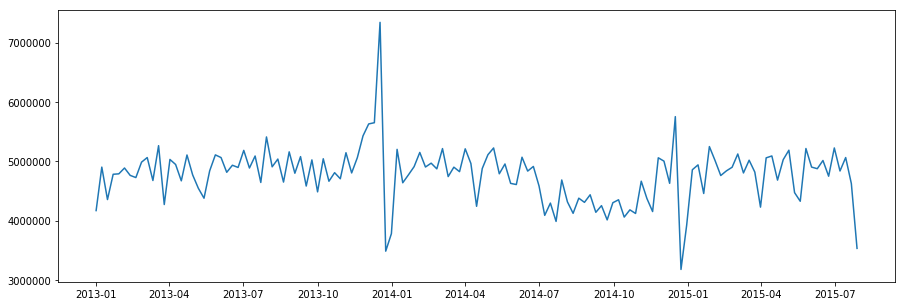

In [60]:
plot_ts('Customers','7d')

Text(0.5, 1.0, 'Sales')

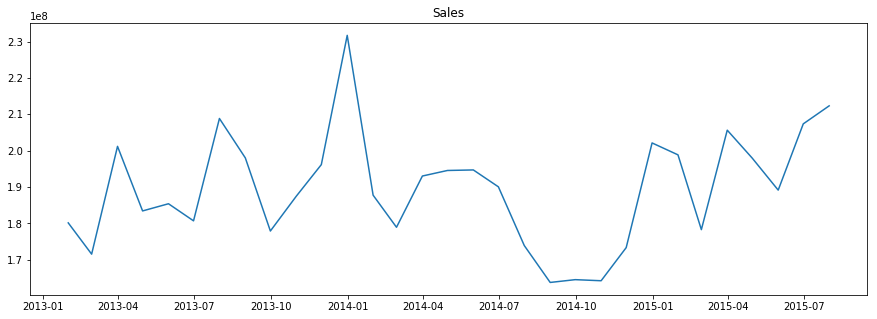

In [61]:
#月別
plot_ts('Sales','1m')
plt.title('Sales')

Text(0.5, 1.0, 'Customers')

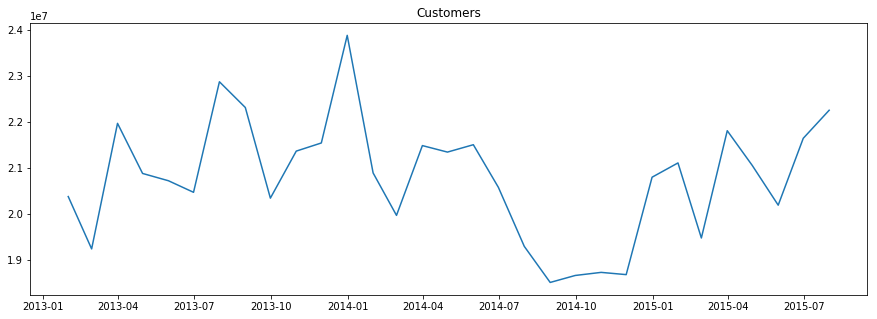

In [62]:
plot_ts('Customers','1m')
plt.title('Customers')

顧客数と売上の変化は基本的に一致しています


feature別売上合計

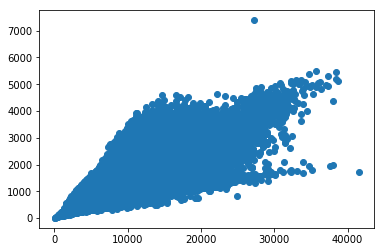

In [64]:
plt.scatter(df['Sales'],df['Customers'])

In [65]:
def plot_feature_sales(feature):
    data = df.groupby(feature).sum().reset_index()
    data = data.loc[~(data['Sales']==0),[feature,'Sales']]
    return data[feature],data['Sales']

In [66]:
plot_feature_sales('PromoInterval')

(0     Feb,May,Aug,Nov
 1     Jan,Apr,Jul,Oct
 2    Mar,Jun,Sept,Dec
 3             NoPromo
 Name: PromoInterval, dtype: object, 0     629419836
 1    1630451279
 2     501317598
 3    3111542628
 Name: Sales, dtype: int64)

In [67]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'SalesPerCustomer'],
      dtype='object')

In [68]:
# sns.pairplot(df)
data = df.groupby('DayOfWeek').count().reset_index()
data[['DayOfWeek','Date']]
#     return data[feature],data['Date']

,DayOfWeek,Date
0,1,137553
1,2,143950
2,3,141918
3,4,134622
4,5,138629
5,6,144050
6,7,3593


In [69]:
def plot_categorial(feature):
    data = df.groupby(feature).mean().reset_index()
    data = data[[feature,'Sales']]
    return data[feature],data['Sales']

カテゴリー変数に関する集計

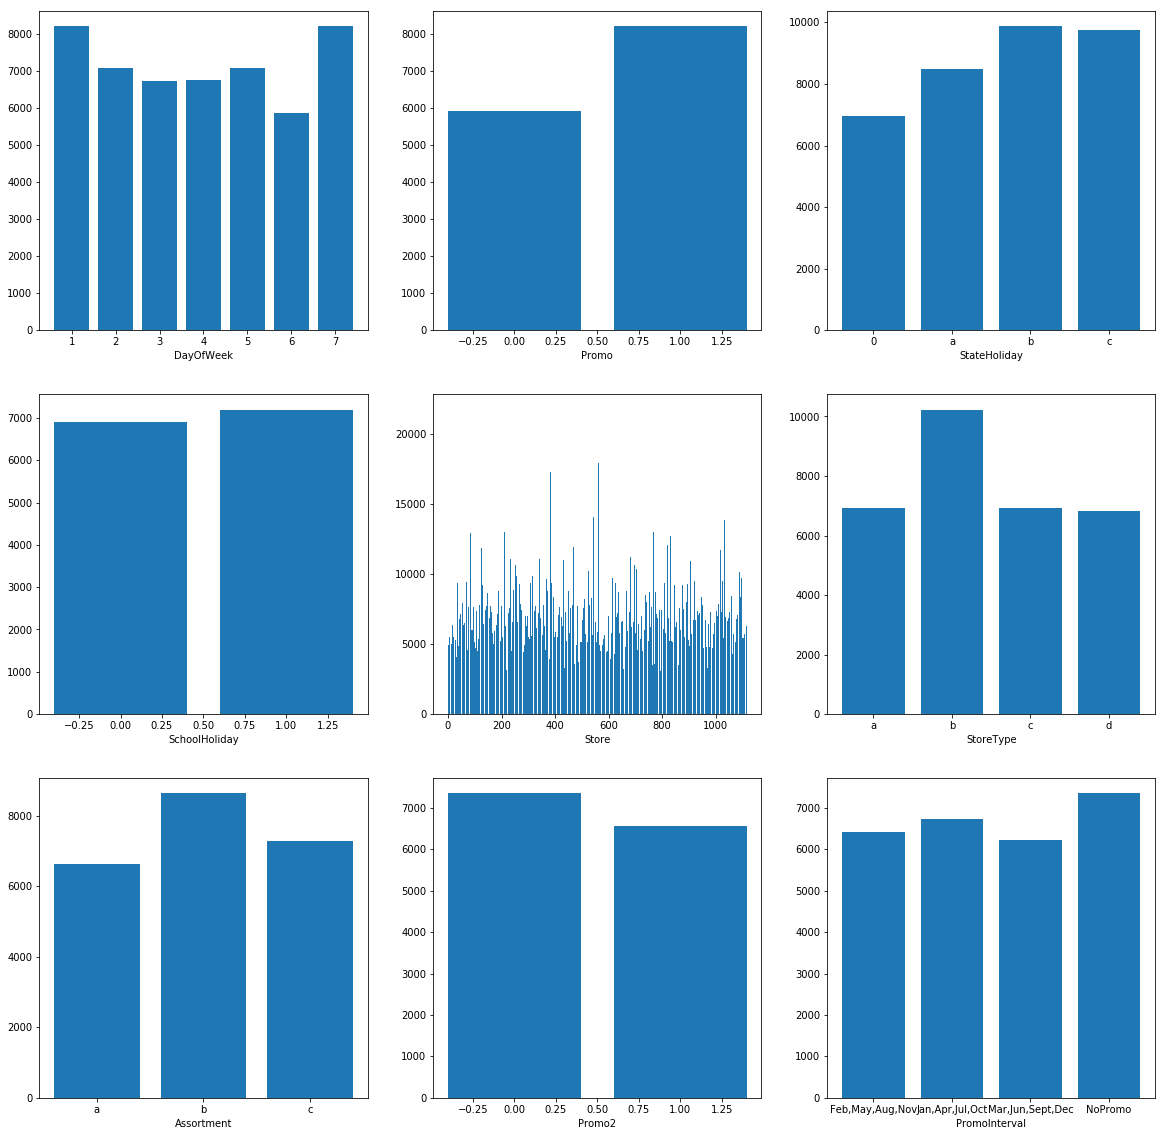

In [70]:
categorical_features = ['DayOfWeek',
       'Promo', 'StateHoliday', 'SchoolHoliday', 'Store', 'StoreType',
       'Assortment',
       'Promo2','PromoInterval']

fig = plt.figure(figsize=(20,20));
for i,f in enumerate(categorical_features):
    ax=plt.subplot(3,3,i+1);
    left,height = plot_categorial(f)
    ax.bar(x=left,height=height);
    ax.set_xlabel(f);

In [71]:
numeric_features = ['CompetitionDistance']


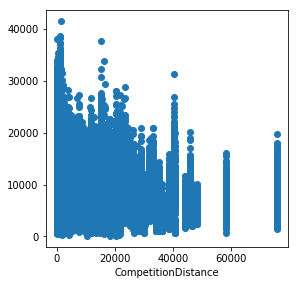

In [72]:
fig = plt.figure(figsize=(20,20));
for i,f in enumerate(numeric_features):
    ax=plt.subplot(4,4,i+1);
    ax.scatter(df[f],df['Sales']);
    ax.set_xlabel(f);

特に強い相関がある特徴量がなさそうです。  
ライバルとの距離という特徴量は売り上げと相関がある  

### 追加の特徴量を作成し、モデリングして予測しましょう。